# COGS 118A - Final Project
## Comparison of Binary Classifying Algorithms

Name: Alberto Montilla Ochoa (A13573544)

## Imports

In [869]:
# KNN
from sklearn.neighbors import KNeighborsClassifier

# Random Forest
from sklearn.ensemble import RandomForestClassifier

# Decison Tree
from sklearn.tree import DecisionTreeClassifier

# Testing and Displaying
import time
import sklearn as skl
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random as rand
from scipy import stats
from sklearn import tree
from sklearn.model_selection import GridSearchCV
%config InlineBackend.figure_format = 'retina'

## Data

In [870]:
# Function that normalizes a dataset keeping labels as they are
def norm_data(data):
    l = len(data)
    lim = len(data[0]) - 1
    temp = np.delete(data, lim, axis=1)
    data_norm = stats.zscore(temp)
    data_norm = np.append(data_norm, np.reshape(data[:,lim], (l, 1)), 1)
    return(data_norm)

### Ionosphere Data

In [877]:
# Load data
iono_data = np.genfromtxt('ionosphere.data.txt', delimiter=',', dtype = float)
iono_data_str = np.genfromtxt('ionosphere.data.txt', delimiter=',', dtype = str)

In [878]:
# Clean data to have binary labels
Y = np.ones((len(iono_data),1))
n = 0
for i in iono_data_str:
    if i[34] == 'g':
        Y[n] = int(1)
    else:
        Y[n] = 0
    n += 1
Y = Y.astype(int)

In [879]:
# Delete useless columns (non numerical bookeeping values)
iono_data = np.delete(iono_data, 34, axis=1)
iono_data = np.delete(iono_data, 0, axis=1)
iono_data = np.delete(iono_data, 0, axis=1)
iono_data = np.append(iono_data, Y, 1)

In [880]:
# Normalize data
iono_data_norm = norm_data(iono_data)

In [881]:
# Compute dataset with less parameters
iono_data_less = np.delete(iono_data, 0, axis=1)
for i in [0,1,1,2,2,3,3,4,4,5,5,6,6,7,7,1,2,3,4,5,1,2,3,1,1,1,2,2,0,0]:
    iono_data_less = np.delete(iono_data_less, i, axis=1)
    
iono_data_less_norm = norm_data(iono_data_less)

In [882]:
print(iono_data.shape)
print(iono_data_norm.shape)
print(iono_data_less.shape)
print(iono_data_less_norm.shape)

(351, 33)
(351, 33)
(351, 2)
(351, 2)


### Transfusion Data

In [883]:
# Load and nrmalize data
transfusion_data = np.genfromtxt('transfusion.data.txt', delimiter=',', dtype=int)
transfusion_data_norm = norm_data(transfusion_data)

In [884]:
# Compute dataset with less parameters
transfusion_data_less = np.delete(transfusion_data, 0, axis=1)
for i in [1]:
    transfusion_data_less = np.delete(transfusion_data_less, i, axis=1)
    
transfusion_data_less_norm = norm_data(transfusion_data_less)

In [885]:
print(transfusion_data.shape)
print(transfusion_data_norm.shape)
print(transfusion_data_less.shape)
print(transfusion_data_less_norm.shape)

(748, 5)
(748, 5)
(748, 3)
(748, 3)


### Occupancy Data

In [886]:
# Load data
occupancy_data1 = np.genfromtxt('occupancy1.data.txt', delimiter=',', dtype = float)
occupancy_data2 = np.genfromtxt('occupancy2.data.txt', delimiter=',', dtype = float)
occupancy_data3 = np.genfromtxt('occupancy3.data.txt', delimiter=',', dtype = float)

In [887]:
# Clean useless columns (non numerical bookeeping values) and combine
occupancy_data = np.concatenate((occupancy_data1, occupancy_data2, occupancy_data3), axis=0)

occupancy_data = np.delete(occupancy_data, 0, axis=1)
occupancy_data = np.delete(occupancy_data, 0, axis=1)

In [888]:
# Normalize data
occupancy_data_norm = norm_data(occupancy_data)

In [889]:
# Attain random half of the data
np.random.seed(0)
np.random.shuffle(occupancy_data)

occupancy_data_half = np.split(occupancy_data, 4)[0]
occupancy_data_half_norm = norm_data(occupancy_data_half)

In [890]:
# Compute dataset with less parameters
occupancy_data_less = np.delete(occupancy_data, 0, axis=1)
for i in [0,0,0]:
    occupancy_data_less = np.delete(occupancy_data_less, i, axis=1)
    
occupancy_data_less_norm = norm_data(occupancy_data_less)

In [891]:
# Attain random half of the data
np.random.seed(0)
np.random.shuffle(occupancy_data_less)

occupancy_data_less_half = np.split(occupancy_data_less, 4)[0]
occupancy_data_less_half_norm = norm_data(occupancy_data_less_half)

In [892]:
print(occupancy_data.shape)
print(occupancy_data_norm.shape)
print(occupancy_data_half.shape)
print(occupancy_data_half_norm.shape)
print(occupancy_data_less.shape)
print(occupancy_data_less_norm.shape)
print(occupancy_data_less_half.shape)
print(occupancy_data_less_half_norm.shape)

(20560, 6)
(20560, 6)
(5140, 6)
(5140, 6)
(20560, 2)
(20560, 2)
(5140, 2)
(5140, 2)


### Data Partitioning

In [893]:
# Function that partitions data based on given training/test ratio
def partition(data, x_ratio, train_or_test):
    # Shuffle Data
    np.random.seed(0)
    np.random.shuffle(data)   

    # X Y Division
    X = data[:, 0:-1]      
    Y = data[:, -1]
    
    # Training, validation and test partition
    X_train_val = X[:int(x_ratio*len(X))]     # Train + val set features
    X_test      = X[int(x_ratio*len(X)):]     # Test set features
    Y_train_val = Y[:int(x_ratio*len(Y))]     # Train + val set labels
    Y_test      = Y[int(x_ratio*len(Y)):]     # Test set labels
    
    if train_or_test == 'train':
        return X_train_val, Y_train_val
    
    else:
        return X_test, Y_test

### Heatmap Function

In [894]:
# Draw hearmaps from test and validation accuracies per parameter
def draw_heatmap_linear(acc, acc_desc, param_list):
    plt.figure(figsize = (2,4))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', yticklabels=param_list, xticklabels=[])
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(ylabel='$param$')
    plt.title(acc_desc + ' w.r.t $param$')
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()

In [895]:
# Reshape accuracy arrays to be in form that heatmap function takes
def reshape_acc(train, val):
    train_acc = []
    val_acc = []
    
    for t_acc in train:
        train_acc.append([t_acc])
        
    for v_acc in val:
        val_acc.append([v_acc])
    
    return train_acc, val_acc

## Training Functions

Perform grid search for best parameter

3-fold cross-validation and grid search

In [896]:
# Finds best parameter based on validation accuracy
def best_param(val_acc, param_list):
    best_par = 0
    best_acc = 0
    for i in range(0,len(val_acc)):
        if val_acc[i] > best_acc:
            best_acc = val_acc[i]
            best_par = param_list[i]
            
    return best_par, best_acc

In [897]:
# Function that runs data training trials on a given data, partition, classifier, and parameters
def data_train_trial(data, x_part_ratio, classifier, param_list, param_name, heatmap):

    param_grid = {param_name: param_list}
    
    train_acc = []
    val_acc = []
    
    # 3 trials
    trials = 3
    for i in range (0,trials):
    
        # Attain train data from partition
        X_train_val, Y_train_val = partition(data, x_part_ratio, 'train')
    
        # Classifier
        grid_search = GridSearchCV(classifier, param_grid)
        grid_search.fit(X_train_val, Y_train_val)

        if i == 0:
            train_acc = grid_search.cv_results_['mean_train_score']/trials
            val_acc = grid_search.cv_results_['mean_test_score']/trials
    
        else:
            train_acc += grid_search.cv_results_['mean_train_score']/trials
            val_acc += grid_search.cv_results_['mean_test_score']/trials
        
    # Visualize Heatmaps
    if heatmap:
        draw_heatmap_linear(train_acc.reshape(-1,1), 'train accuracy', param_list)
        draw_heatmap_linear(val_acc.reshape(-1,1), 'val accuracy', param_list)
    
    print(best_param(val_acc, param_list))
    return best_param(val_acc, param_list)

In [898]:
# Testing of a classifier on a given data and partition
def data_test(data, x_part_ratio, classifier):
    
    # Attain train data from partition
    X_test, Y_test = partition(data, x_part_ratio, 'test')
    
    # Fit Data
    classifier.fit(X_test, Y_test)
    
    # Calculate and return accuracy
    test_acc = classifier.score(X_test, Y_test)
    print(test_acc)

### Decision Tree

In [899]:
# Executes decison tree training
def dt_train(data, x_part_ratio, D_list, heatmap):
    classifier = DecisionTreeClassifier()
    return data_train_trial(data, x_part_ratio, classifier, D_list, 'max_depth', heatmap)

In [900]:
# Executes decison tree testing
def dt_test(data, x_part_ratio, depth):
    classifier = DecisionTreeClassifier(max_depth=depth)
    test_acc = data_test(data, x_part_ratio, classifier)
    return(test_acc)

### KNN

In [923]:
# Executes knn training
def knn_train(data, x_part_ratio, K_list, heatmap):
    classifier = KNeighborsClassifier()
    return data_train_trial(data, x_part_ratio, classifier, K_list, 'n_neighbors', heatmap)

In [902]:
# Executes knn testing
def knn_test(data, x_part_ratio, k):
    classifier = KNeighborsClassifier(n_neighbors=k)
    test_acc = data_test(data, x_part_ratio, classifier)
    return(test_acc)

### Random Forest

In [903]:
# Executes random forest training
def rf_train(data, x_part_ratio, D_list, heatmap):
    classifier = RandomForestClassifier()    
    return data_train_trial(data, x_part_ratio, classifier, D_list, 'max_depth', heatmap)

In [904]:
# Executes random forest testing
def rf_test(data, x_part_ratio, depth):
    classifier = RandomForestClassifier(max_depth=depth)  
    test_acc = data_test(data, x_part_ratio, classifier)
    return(test_acc)

## Training and Testing Functions

In [905]:
# Trains given classifier and performs cross validation o a given dataset and classifier
def train(data, classifier, param_list, heatmap):
    
    # Determine training function
    if classifier == 'dt':
        func = dt_train
    elif classifier == 'knn':
        func = knn_train
    elif classifier == 'rf':
        func = rf_train
    
    # Train classifier
    print('80/20 Partition best parameter')
    best_param80, test_acc = func(data, 0.8, param_list, heatmap)
    
    print('\n50/50 Partition best parameter')
    best_param50, test_acc = func(data, 0.5, param_list, heatmap)
    
    print('\n20/80 Partition best parameter')
    best_param20, test_acc = func(data, 0.2, param_list, heatmap)
    
    return best_param80, best_param50, best_param20

In [906]:
# Performs classifier testing on given data based on best hyper parameter
def test(data, classifier, param80, param50, param20):
    # Determine training function
    if classifier == 'dt':
        func = dt_test
    elif classifier == 'knn':
        func = knn_test
    elif classifier == 'rf':
        func = rf_test
        
    print('80/20 test accuracy')
    func(data, 0.8, param80)
    time.sleep(.5)
    print('\n50/50 test accuracy')
    func(data, 0.5, param50)
    time.sleep(.5)
    print('\n20/80 test accuracy')
    func(data, 0.2, param20)
    time.sleep(.5)

In [913]:
# Compiles testing and training into a single function
def trial_test_compiler(data, data_norm, heatmap):
    
    # Decision Tree
    print('\033[4m\033[1m' + 'Decision Tree\n' + '\033[0m')
    print('\tTrain\n')
    Dt_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 17, 30, 50]
    best_param80, best_param50, best_param20 = train(data, 'dt', Dt_list, heatmap)
    print('\n\tTest\n')
    test(data, 'dt', best_param80, best_param50, best_param20)
    
    # KNN
    print('\033[4m\033[1m' + '\n\nKNN\n' + '\033[0m')
    print('\tTrain\n')
    K_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 17, 30]
    best_param80, best_param50, best_param20 = train(data_norm, 'knn', K_list, heatmap)
    print('\n\tTest\n')
    test(data, 'knn', best_param80, best_param50, best_param20)
    
    # Random Forest
    print('\033[4m\033[1m' + '\n\nRandom Forest\n' + '\033[0m')
    print('\tTrain\n')
    Rf_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 17, 30, 50]
    best_param80, best_param50, best_param20 = train(data, 'rf', Rf_list, heatmap)
    print('\n\tTest\n')
    test(data, 'rf', best_param80, best_param50, best_param20)

## Experimenting Phase

### Ionosphere Data

In [914]:
trial_test_compiler(iono_data, iono_data_norm, False)

Decision Tree

	Train

80/20 Partition best parameter
(2, 0.8892857142857142)

50/50 Partition best parameter
(2, 0.8914285714285715)

20/80 Partition best parameter
(2, 0.8523809523809525)

	Test

80/20 test accuracy
0.9436619718309859

50/50 test accuracy
0.9488636363636364

20/80 test accuracy
0.9252669039145908


KNN

	Train

80/20 Partition best parameter
(2, 0.8773809523809524)

50/50 Partition best parameter
(2, 0.8799999999999999)

20/80 Partition best parameter
(2, 0.8380952380952381)

	Test

80/20 test accuracy
1.0

50/50 test accuracy
0.9886363636363636

20/80 test accuracy
0.9822064056939501


Random Forest

	Train

80/20 Partition best parameter
(9, 0.9285714285714286)

50/50 Partition best parameter
(17, 0.9219047619047618)

20/80 Partition best parameter
(5, 0.8619047619047618)

	Test

80/20 test accuracy
1.0

50/50 test accuracy
1.0

20/80 test accuracy
0.9679715302491103


### Transfusion Data

In [915]:
trial_test_compiler(iono_data, iono_data_norm, False)

Decision Tree

	Train

80/20 Partition best parameter
(2, 0.894047619047619)

50/50 Partition best parameter
(6, 0.8780952380952382)

20/80 Partition best parameter
(30, 0.8952380952380952)

	Test

80/20 test accuracy
0.9436619718309859

50/50 test accuracy
0.9829545454545454

20/80 test accuracy
1.0


KNN

	Train

80/20 Partition best parameter
(2, 0.888095238095238)

50/50 Partition best parameter
(2, 0.8838095238095238)

20/80 Partition best parameter
(2, 0.8714285714285714)

	Test

80/20 test accuracy
0.971830985915493

50/50 test accuracy
0.9886363636363636

20/80 test accuracy
0.9750889679715302


Random Forest

	Train

80/20 Partition best parameter
(17, 0.925)

50/50 Partition best parameter
(30, 0.9142857142857144)

20/80 Partition best parameter
(30, 0.8952380952380954)

	Test

80/20 test accuracy
0.9859154929577465

50/50 test accuracy
1.0

20/80 test accuracy
0.99644128113879


### Occupancy Data (fourth the size)

In [916]:
trial_test_compiler(occupancy_data_half, occupancy_data_half_norm, False)

Decision Tree

	Train

80/20 Partition best parameter
(2, 0.9903534370946823)

50/50 Partition best parameter
(1, 0.988845654993515)

20/80 Partition best parameter
(1, 0.9876783398184177)

	Test

80/20 test accuracy
0.9902723735408561

50/50 test accuracy
0.9929961089494164

20/80 test accuracy
0.9919747081712063


KNN

	Train

80/20 Partition best parameter
(5, 0.9900291828793775)

50/50 Partition best parameter
(7, 0.9883268482490273)

20/80 Partition best parameter
(9, 0.9870298313878081)

	Test

80/20 test accuracy
0.9873540856031129

50/50 test accuracy
0.9929961089494164

20/80 test accuracy
0.9910019455252919


Random Forest

	Train

80/20 Partition best parameter
(17, 0.9904345006485085)

50/50 Partition best parameter
(6, 0.9892347600518807)

20/80 Partition best parameter
(7, 0.9909208819714657)

	Test

80/20 test accuracy
1.0

50/50 test accuracy
0.9929961089494164

20/80 test accuracy
0.9929474708171206


### Occupancy Data (full)

In [917]:
trial_test_compiler(occupancy_data, occupancy_data_norm, False)

Decision Tree

	Train

80/20 Partition best parameter
(8, 0.9905155642023346)

50/50 Partition best parameter
(7, 0.9892671854734112)

20/80 Partition best parameter
(1, 0.9901913099870299)

	Test

80/20 test accuracy
0.9980544747081712

50/50 test accuracy
0.9948443579766537

20/80 test accuracy
0.989238813229572


KNN

	Train

80/20 Partition best parameter
(1, 0.9928664072632944)

50/50 Partition best parameter
(3, 0.9919909208819715)

20/80 Partition best parameter
(5, 0.9891374837872893)

	Test

80/20 test accuracy
1.0

50/50 test accuracy
0.9922178988326849

20/80 test accuracy
0.9922786964980544


Random Forest

	Train

80/20 Partition best parameter
(50, 0.9914680609597925)

50/50 Partition best parameter
(8, 0.9913099870298314)

20/80 Partition best parameter
(9, 0.9893806744487679)

	Test

80/20 test accuracy
0.9995136186770428

50/50 test accuracy
0.9928988326848249

20/80 test accuracy
0.9956833657587548


### Occupancy Data (fourth of the size) - With heatmaps

Decision Tree

	Train

80/20 Partition best parameter


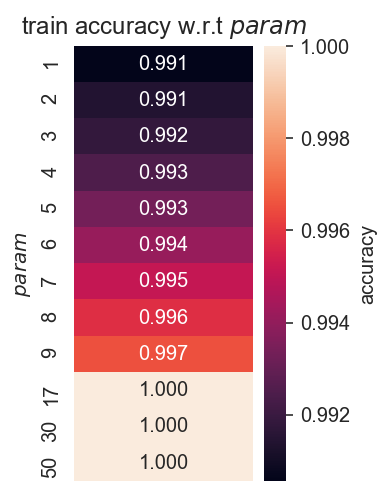

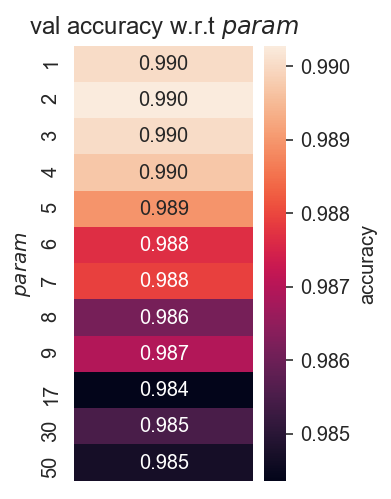

(2, 0.9902723735408561)

50/50 Partition best parameter


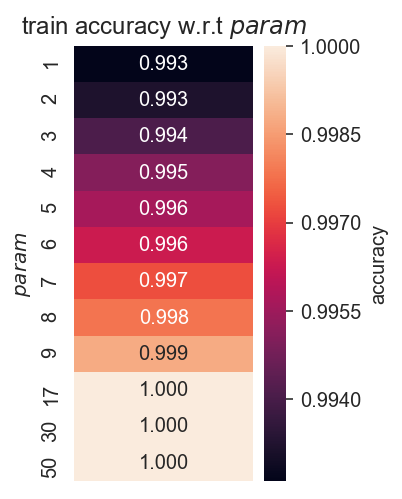

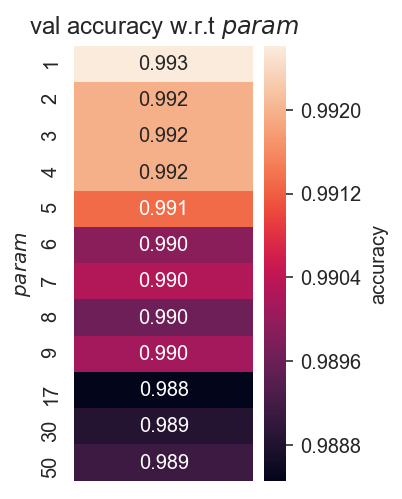

(1, 0.9926070038910506)

20/80 Partition best parameter


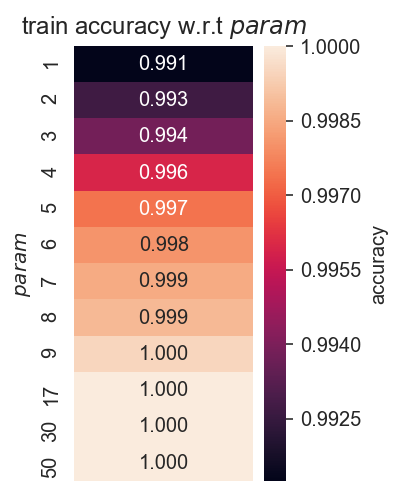

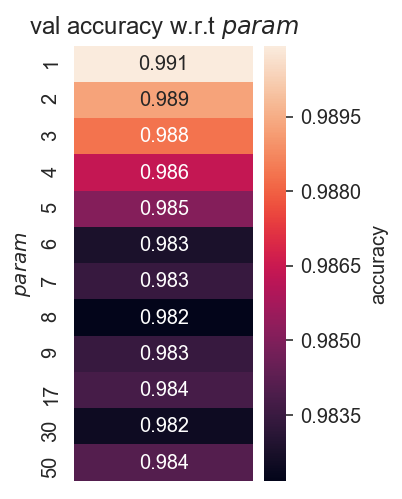

(1, 0.9909208819714657)

	Test

80/20 test accuracy
0.9892996108949417

50/50 test accuracy
0.9891050583657588

20/80 test accuracy
0.9905155642023347


KNN

	Train

80/20 Partition best parameter


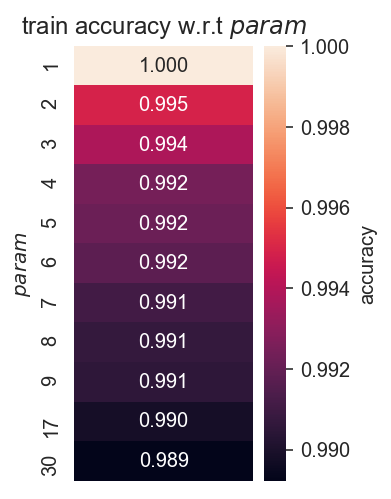

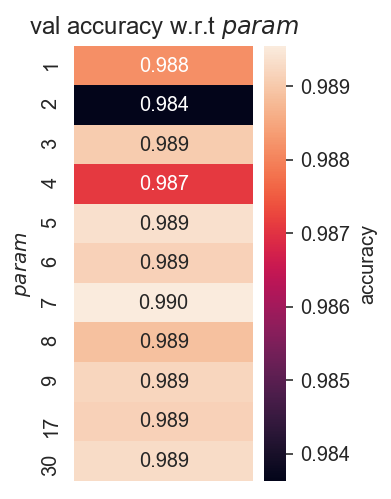

(7, 0.9895428015564203)

50/50 Partition best parameter


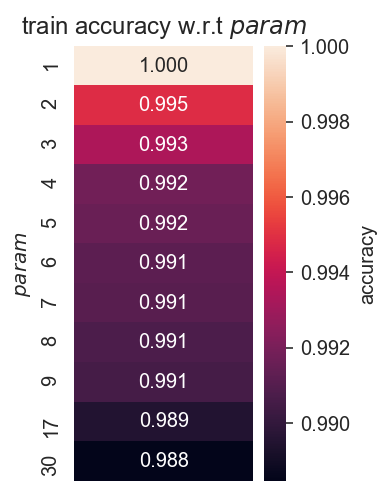

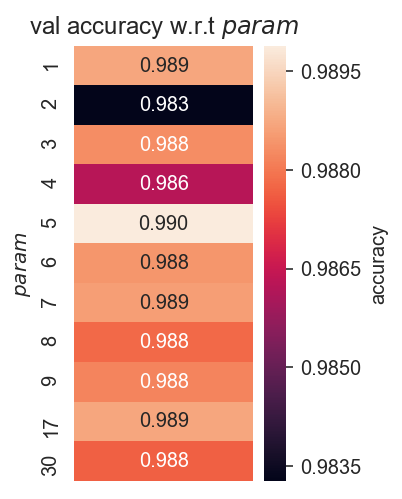

(5, 0.9898832684824903)

20/80 Partition best parameter


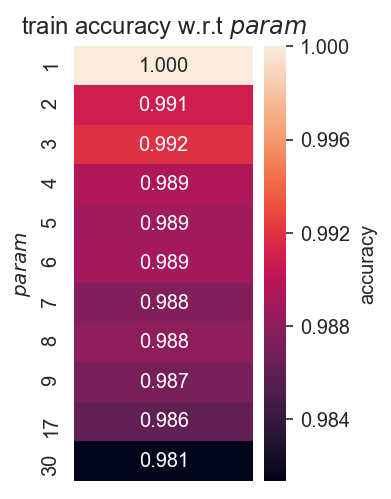

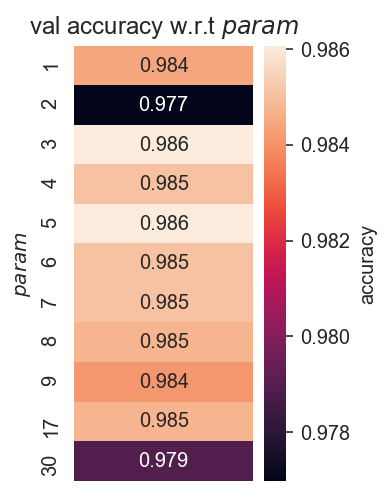

(3, 0.9860570687418937)

	Test

80/20 test accuracy
0.9892996108949417

50/50 test accuracy
0.9914396887159533

20/80 test accuracy
0.992704280155642


Random Forest

	Train

80/20 Partition best parameter


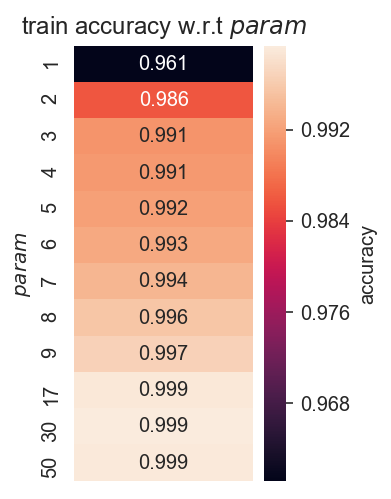

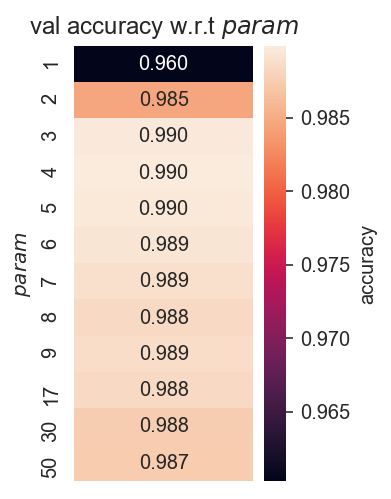

(4, 0.9898670557717251)

50/50 Partition best parameter


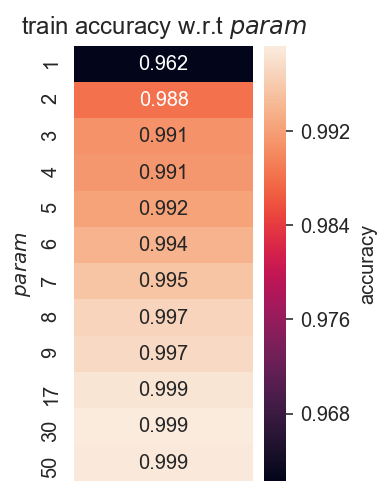

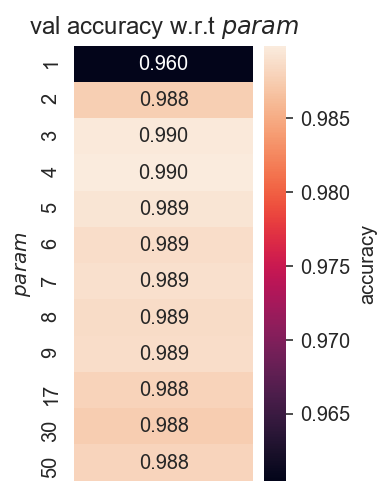

(4, 0.9898832684824903)

20/80 Partition best parameter


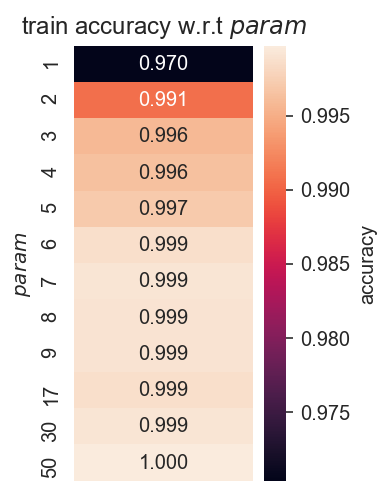

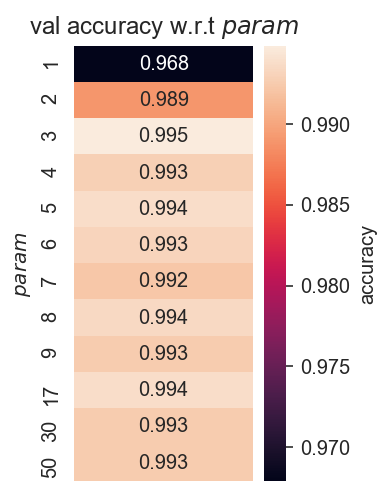

(3, 0.9948119325551232)

	Test

80/20 test accuracy
0.995136186770428

50/50 test accuracy
0.9941634241245136

20/80 test accuracy
0.9917315175097277


In [918]:
trial_test_compiler(occupancy_data_half, occupancy_data_half_norm, True)

## Observations

Based on the results abve, the dataset do not appear to be challenging enough, the analysis is hard to show when the accuracies are so high, so for the following results the data will have less parameters and therefore less information to classify on, meaning that the accuracy of the classifiers should decrease

## Testing With Reduced Parameters

### Ionosphere Data (reduced features)

In [919]:
trial_test_compiler(iono_data_less, iono_data_less_norm, False)

Decision Tree

	Train

80/20 Partition best parameter
(4, 0.8452380952380952)

50/50 Partition best parameter
(4, 0.8247619047619048)

20/80 Partition best parameter
(4, 0.8476190476190475)

	Test

80/20 test accuracy
0.9014084507042254

50/50 test accuracy
0.8409090909090909

20/80 test accuracy
0.8505338078291815


KNN

	Train

80/20 Partition best parameter
(5, 0.8488095238095238)

50/50 Partition best parameter
(3, 0.7961904761904761)

20/80 Partition best parameter
(3, 0.7952380952380953)

	Test

80/20 test accuracy
0.9014084507042254

50/50 test accuracy
0.875

20/80 test accuracy
0.8078291814946619


Random Forest

	Train

80/20 Partition best parameter
(4, 0.844047619047619)

50/50 Partition best parameter
(5, 0.8133333333333334)

20/80 Partition best parameter
(4, 0.7619047619047619)

	Test

80/20 test accuracy
0.9014084507042254

50/50 test accuracy
0.875

20/80 test accuracy
0.8469750889679716


### Transfusion Data (reduced features)

In [920]:
trial_test_compiler(transfusion_data_less, transfusion_data_less_norm, False)

Decision Tree

	Train

80/20 Partition best parameter
(3, 0.7692307692307692)

50/50 Partition best parameter
(1, 0.7638146167557932)

20/80 Partition best parameter
(1, 0.7293064876957495)

	Test

80/20 test accuracy
0.8066666666666666

50/50 test accuracy
0.7807486631016043

20/80 test accuracy
0.7462437395659433


KNN

	Train

80/20 Partition best parameter
(30, 0.7759197324414715)

50/50 Partition best parameter
(17, 0.7798573975044563)

20/80 Partition best parameter
(8, 0.7516778523489933)

	Test

80/20 test accuracy
0.7866666666666666

50/50 test accuracy
0.786096256684492

20/80 test accuracy
0.7896494156928213


Random Forest

	Train

80/20 Partition best parameter
(3, 0.7675585284280937)

50/50 Partition best parameter
(1, 0.7611408199643493)

20/80 Partition best parameter
(1, 0.7449664429530202)

	Test

80/20 test accuracy
0.8133333333333334

50/50 test accuracy
0.7406417112299465

20/80 test accuracy
0.7562604340567612


### Occupancy Data (reduced features)

In [921]:
trial_test_compiler(occupancy_data_less, occupancy_data_less_norm, False)

Decision Tree

	Train

80/20 Partition best parameter
(30, 0.8089940012970169)

50/50 Partition best parameter
(50, 0.7921206225680935)

20/80 Partition best parameter
(2, 0.7857490272373542)

	Test

80/20 test accuracy
0.9620622568093385

50/50 test accuracy
0.9458171206225681

20/80 test accuracy
0.7867825875486382


KNN

	Train

80/20 Partition best parameter
(1, 0.8125202658884565)

50/50 Partition best parameter
(2, 0.8017185473411155)

20/80 Partition best parameter
(6, 0.7830739299610896)

	Test

80/20 test accuracy
0.9905155642023347

50/50 test accuracy
0.8890077821011673

20/80 test accuracy
0.8468506809338522


Random Forest

	Train

80/20 Partition best parameter
(17, 0.8017590791180285)

50/50 Partition best parameter
(9, 0.7950713359273671)

20/80 Partition best parameter
(3, 0.7866407263294424)

	Test

80/20 test accuracy
0.9185311284046692

50/50 test accuracy
0.8158560311284047

20/80 test accuracy
0.7876337548638133


### Occupancy Data (reduced features and fourth the size)

In [922]:
trial_test_compiler(occupancy_data_less_half, occupancy_data_less_half_norm, False)

Decision Tree

	Train

80/20 Partition best parameter
(2, 0.7892347600518808)

50/50 Partition best parameter
(4, 0.787289234760052)

20/80 Partition best parameter
(2, 0.7928015564202335)

	Test

80/20 test accuracy
0.7879377431906615

50/50 test accuracy
0.7945525291828793

20/80 test accuracy
0.7896400778210116


KNN

	Train

80/20 Partition best parameter
(30, 0.7878566796368354)

50/50 Partition best parameter
(30, 0.7887159533073931)

20/80 Partition best parameter
(30, 0.7892347600518808)

	Test

80/20 test accuracy
0.7811284046692607

50/50 test accuracy
0.7929961089494163

20/80 test accuracy
0.796692607003891


Random Forest

	Train

80/20 Partition best parameter
(7, 0.7902885862516213)

50/50 Partition best parameter
(3, 0.792088197146563)

20/80 Partition best parameter
(3, 0.7960440985732815)

	Test

80/20 test accuracy
0.8122568093385214

50/50 test accuracy
0.7953307392996108

20/80 test accuracy
0.7855058365758755
